In [1]:
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import petsc4py
%matplotlib inline 

# Static hyperelasticity #
Hyperelasticity: internal energy only depends on state.

$$
\begin{align}
- \text{div} P = B & \text{ in } \Omega \\
u = g & \text{ on } \Gamma_D \\
P\cdot n = T & \text{ on } \Gamma_N 
\end{align}
$$

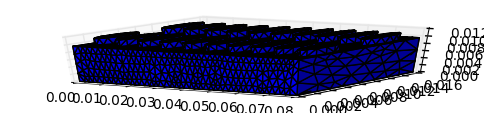

In [2]:
g = Constant(0.)
Tt = Constant(5000.)

# Material properties
rho = Constant(1450.)
# E = 0.0065e9
# nu = 0.41*1e9

mesh = Mesh("./lego_beam.xml")
plot(mesh)

V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Mark boundary subdomians
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] < 0.1*0.001 + DOLFIN_EPS
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return x[0] > 10*0.008 - 0.1*0.001 - DOLFIN_EPS
    
# set boundary markers
boundary_markers = FacetFunction('size_t', mesh)
boundaries = FacetFunction("size_t", mesh)
boundaries.set_all(0)
left = BoundaryLeft()
left.mark(boundary_markers, 1)
right = BoundaryRight()
right.mark(boundary_markers, 2)

# Define measure ds to apply markers
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define boundary conditions on the domain V
c = Constant((0., 0., 0.))
bcl = DirichletBC(V, c, left)
bcs = [bcl]

# Define loads:
B = Constant((0.0, 0.0, -Constant(g*rho)))  # Body force per unit volume
T = Constant((0.0, 0.0, -Constant(Tt)))  # Traction force on the boundary

# Solve using strain energy #

Solving the displacement of the lego block using strain energy is discussed in [lecture 6 on static hyperelasticity](https://fenicsproject.org/pub/course/lectures/2017-nordic-phdcourse/lecture_06_static_hyperelasticity.pdf).

The code below defines the variational problem using the strain energy approach.

In [3]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Kinematics
I = Identity(len(u))             # Identity tensor
F = I + grad(u)                  # Deformation gradient
C = F.T*F                        # Right Cauchy-Green tensor
E = (C - I)/2

mu = 0.00230 * 1e9
lmbd = 0.0105 * 1e9

# Stored strain energy density
E = variable(E)
W =  lmbd/2 * (tr(E))**2 + mu * tr(E*E)

Pi = W*dx - dot(B, u)*dx - dot(T, u)*ds(2)
dPi = derivative(Pi, u, v)
ddPi = derivative(dPi, u, du)
solve(dPi == 0., u, bcs, J=ddPi)

# Analyze results:
z_vals = assemble(u[2]*dx)
vol2 = assemble(1.0*dx(mesh))
z_direct = z_vals / vol2
print("average z-displacement: ", z_direct)

('average z-displacement: ', -0.004768830449226253)


We define a function to extract modes from a Jacobian which filters out spurious modes from the boundary conditions and stores a pvd file of the seperate modes.

In [4]:
def extract_modes(A, neigs):
    solver = SLEPcEigenSolver(A)
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 0.
    solver.solve(neigs)
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('Lego_block/Modes/modes.pvd')  
    nmodes = 0
    md = 0
    while nmodes < neigs and md < solver.get_number_converged():
        r, c, rx, cx = solver.get_eigenpair(md)
        # Initialize function and assign eigenvector
        tol = 1e-4
        if not (r > 1.-tol and r < 1.+tol):    # filter out spurious eigenvectors
            mode = Function(V)
            mode.rename("mode",'mode')
            mode.vector()[:] = rx
            modes.append(mode)
            eigvalues.append(r)
            # Save mode to file
            vtkfile << (mode, (r))    
            del(mode)
            nmodes += 1
        md += 1
    return modes, eigvalues

After having defined the modal extraction function, we can assemble the Jacobi matrix, apply boundary conditions and extract modes.

The modal vectors are assembles in a numpy array to project the equations of motion later on. 

In [5]:
J = PETScMatrix()
assemble(ddPi, tensor=J)

for bc in bcs:
    bc.apply(J)

neigs = 2**4
modes, evs = extract_modes(J, neigs)
nmodes = len(evs)

N_m = np.zeros((nmodes, len(modes[0].vector())))
for i in range(nmodes):
    N_m[i] = modes[i].vector()[:]

## Modal projection ##
We have found a new equilibrium state of the lego block, now we can linearize around it to apply modal analysis. If a new force is applied we can also calculate the displacement by using modal analysis

If we decompose the displacement modes ($\phi$) and modal participation factors ($q$) we write $u = \phi q$, this can be substituted in the equation of motion:

$$
\mathcal{J} \mathbf{u} = \mathbf{f}
$$

$$
\phi^T \mathcal{J} \phi \mathbf{q} = \phi^T \mathbf{f} \\
\mathcal{J}_m \mathbf{q} = \mathbf{f}_m \\
\mathbf{q} = \mathcal{J}_m^{-1} \mathbf{f}_m
$$

Where if the modes are correctly normalized the projection of the Jacobian is in fact a matrix with eigenvalues on the diagonal.

('L2 norm of difference between eigenvalues and projected Jacobian', 1.6935067520731114e-09)


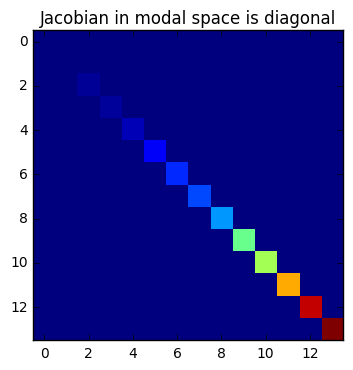

In [6]:
J_modal = np.dot(N_m, np.dot(J.array(), N_m.T))

print("L2 norm of difference between eigenvalues and projected Jacobian", np.linalg.norm(evs - J_modal.diagonal()))

plt.imshow(J_modal, interpolation='nearest')
plt.title("Jacobian in modal space is diagonal")
plt.show()

By projecting the force vector on the modal space, we can calculate the modal participation vector $\mathbf{q}$. The participation per mode is plotted below. 

The participation factor itself converges, however the participation factor in itself does not show the displacement per mode. For this we can look at the average displacement per mode.

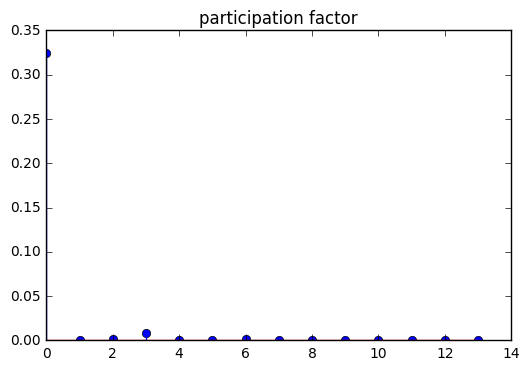

In [7]:
v_test = TestFunction(V)
u_modes = Function(V)
F_t = dot(B, v_test)*dx + dot(T, v_test)*ds(2)
F_vec = assemble(F_t)

F_modal = np.dot(N_m, F_vec.array()[:])
q = np.dot(np.linalg.inv(J_modal), F_modal)

plt.figure()
plt.title("participation factor")
plt.stem(abs(np.array(q).T))
plt.show()

# Store vtk files for paraview
u_modes.vector()[:] = np.dot(N_m.T, q)[:]
vtkfile = File('displacement/modes.pvd')  
vtkfile << (u_modes, 0.)

The total average displacement per mode shows us we have a difference of 5% between the nonlinear and linear solutions, which in general is acceptable for engineering purposes.

Modal analysis can be extended to the nonlinear domain but nonlinear modes are not easy see: [G. Haller, 2016](https://link.springer.com/article/10.1007/s11071-016-2974-z) for more information.

To analyze our results we look both at the total modal displacement for comparison with the nonlinear result, and the average modal displacement per mode to see if the average modal displacement converges. 

The average displacement per mode diminishes with increasing mode number, therefore we can conclude that the average displacement converges. A remark on this measure for the displacement is that symmetric bending modes in the xz-plane will have an average displacement close to zero.

('average z-displacement: ', -0.00455587066739495)
('Difference between modeal (linear) and direct (nonlinear) solutions: ', 0.00021295978183130324)
('Relative difference between modal and direct: ', 0.046744035855845266)


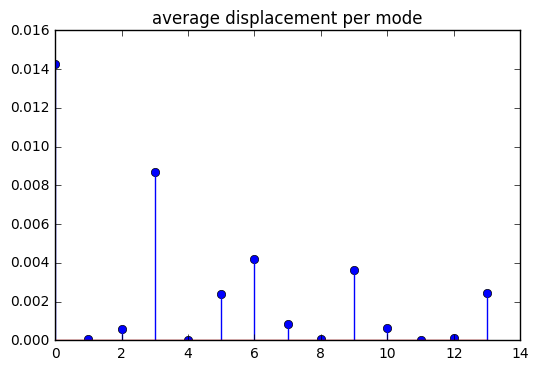

In [8]:
# Analyze results:
z_vals = assemble(u_modes[2]*dx)
vol2 = assemble(1.0*dx(mesh))
z_modal = z_vals / vol2
print("average z-displacement: ", z_modal)
print("Difference between modeal (linear) and direct (nonlinear) solutions: ", (z_modal - z_direct))
print("Relative difference between modal and direct: ", abs((z_modal - z_direct)/z_modal))

# Analyze the results per mode:
z_per_mode = []
for i in range(nmodes):
    average_modal_displacement = assemble(modes[i][2]*dx) / vol2
    z_per_mode.append(average_modal_displacement)

plt.figure()
plt.title("average displacement per mode")
plt.stem(abs(np.array(z_per_mode)))
plt.show()